In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import scipy.stats as stats

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

In [32]:
H0=68
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    DE_contribution=(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z))
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*DE_contribution)#(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

In [33]:
file_path = 'lcparam_full_long.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

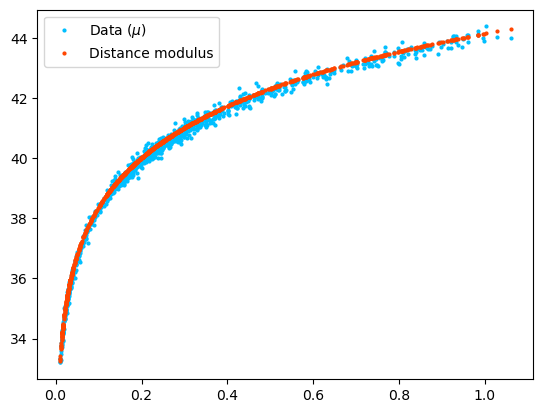

In [34]:
def get_mu(z,H0,Omega_m,Omega_r,w0,wa):
    #z=np.linspace(np.min(z),np.max(z),1000)
    comoving_distance=[]
    distance_modulus=[]
    
    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_m,Omega_r,w0,wa,H0))
        #print(comoving_distance[i])
        if comoving_distance[i]<=0:
            print(f"Invalid distance value: {comoving_distance[i]} for index {i} with redshift {z[i]}")
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
        #print(distance_modulus[i])
    '''
    for i in range(len(z)):
        # Compute comoving distance
        dc = Dc_w0waCDM(hubble_function, z[i], Omega_m, Omega_r, w0, wa, H0)
        comoving_distance.append(dc)

        # Calculate distance * (1 + z)
        distance = dc * (1 + z[i])
        if distance <= 0:
            print(f"Error at index {i}: Invalid distance value {distance} for comoving_distance {dc} and redshift {z[i]}")
            sys.exit("Stopping execution due to invalid distance value.")

        # Compute distance modulus
        modulus = 5 * np.log10(distance) + 25
        distance_modulus.append(modulus)
    '''
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data,H0,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

In [35]:
def log_prior(params):
    Omega_m, Omega_r, w0, wa = params
    if 0 < Omega_m < 1 and 0 <= Omega_r < 0.1 and -2 < w0 < 0 and -2 < wa < 2:
        return 0
    return -np.inf

In [36]:
def log_likelihood(params,z,d,cov_inv):
    Omega_m,Omega_r,w0,wa=params
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    mu=get_mu(z,H0,Omega_m,Omega_r,w0,wa)
    diff=d-mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

In [37]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

In [38]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

In [39]:
initial_guess = [0.319, 0, -0.5, -1]

result = minimize(chi, initial_guess, args=(z_data, mu_data, Sigma_inv), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data, H0, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2578: RuntimeWarning: invalid value encountered in scalar subtract
  p = (x - v) * tmp2 - (x - w) * tmp1


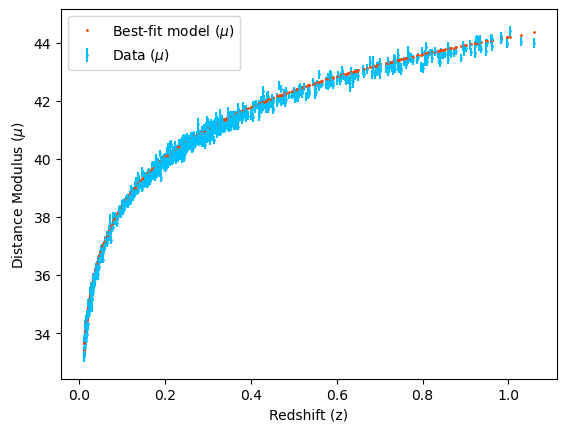

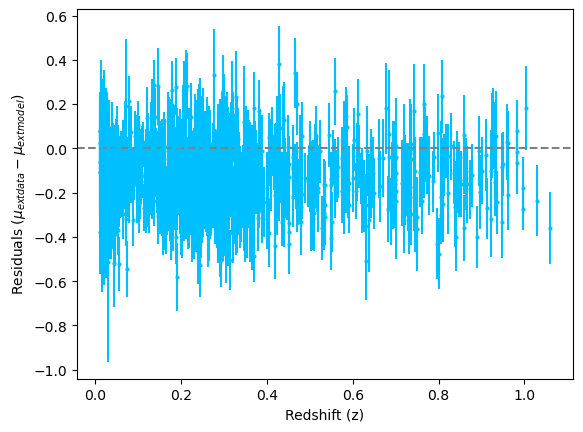

--------------------------------------
Best-fit parameters:
Omega_m: 0.014192478905713792
Omega_r: 0.027826882832840356
w0: -0.8541104621985398
wa: 1.1654650460090747
--------------------------------------
Chi-square: 1011.155941870591
Degrees of freedom: 1018
Reduced chi-square: 0.9932769566508753
--------------------------------------


In [40]:
plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data - mu_model_best
plt.errorbar(z_data, residuals, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("Omega_m:", best_fit_params[0])
print("Omega_r:", best_fit_params[1])
print("w0:", best_fit_params[2])
print("wa:", best_fit_params[3])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data, mu_data, Sigma_inv)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data) - len(best_fit_params)))
print("--------------------------------------")

## MCMC

In [41]:
# Initialize the MCMC sampler
initial = np.array([0.319, 0, -0.5, -1])
ndim = len(initial)
nwalkers = 10

std_Om0 = 1e-2
std_Omr = 1e-7
std_w0_wa = 1e-1

pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_Omr * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)


#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data, mu_data, Sigma_inv))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data, mu_data, Sigma_inv))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))

-585.5023860048603
-630.2043994578676
-636.0411281775926
-600.869249160325
-606.7590630965599
-inf
-694.235228473979
-635.6500292982653
-inf
-inf
-585.5023860048603
-630.2043994578676
-636.0411281775926
-600.869249160325
-606.7590630965599
-inf
-694.235228473979
-635.6500292982653
-inf
-inf


In [42]:
# Run the MCMC sampler
nsteps = 500
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100,thin=10,flat=True)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [06:22<00:00,  1.31it/s]


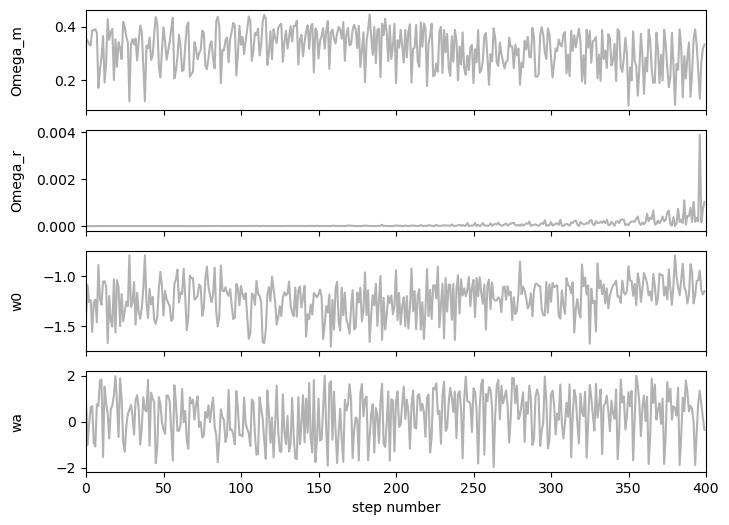

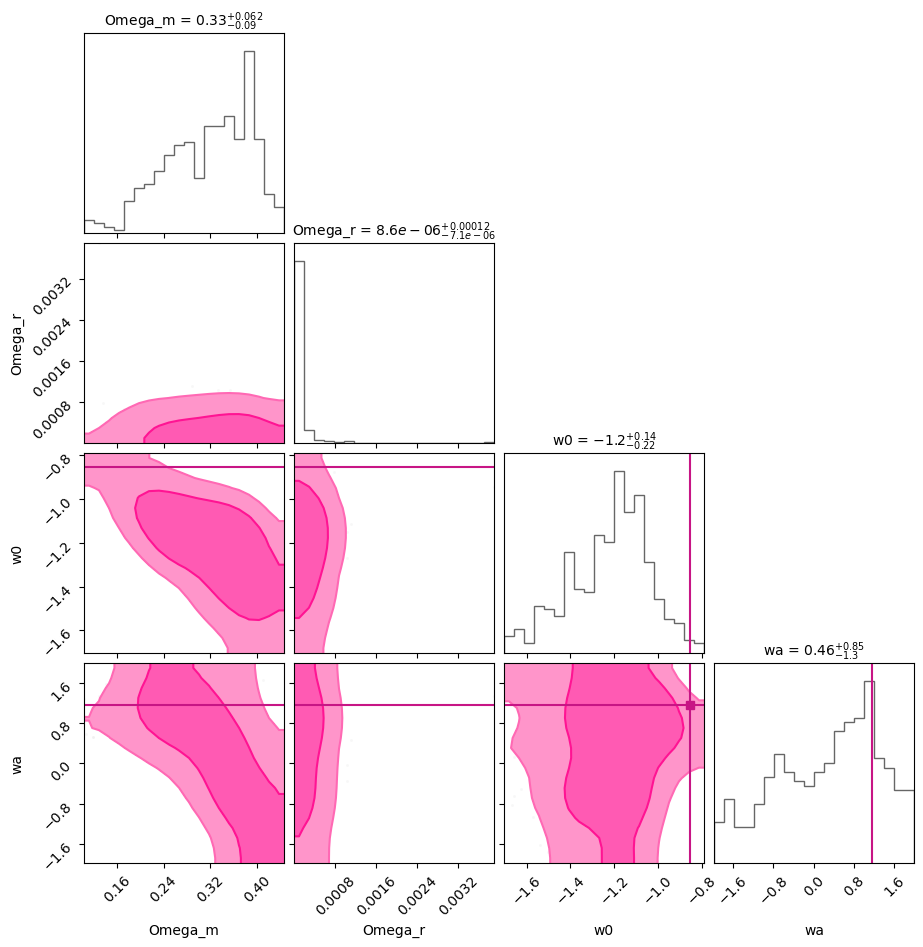

In [43]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])
#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "Omega_r", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#'mediumvioletred'
#'hotpink', 'deeppink'

#'midnightblue'
#'deepskyblue', 'dodgerblue'

level_colors = ['hotpink', 'deeppink']

contourf_kwargs = {
    "colors": ['white', 'hotpink', 'deeppink'],  # Colors for the filled contours
    "alpha": 0.7  # Transparency of the filled contours
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='mediumvioletred',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2g",
                    title_kwargs={"fontsize": 10},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

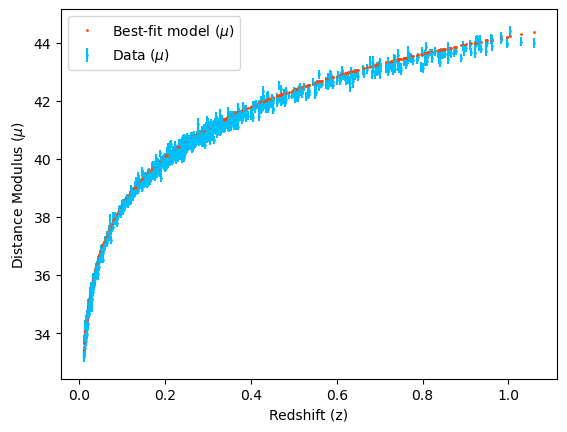

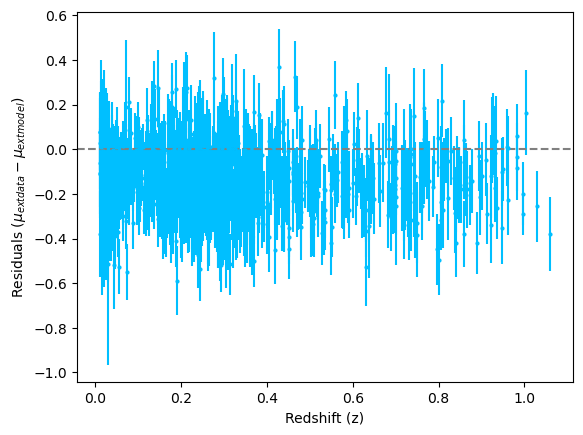

In [44]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data, H0, *best_fit_params_mcmc)

plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data - mu_model_best_mcmc
plt.errorbar(z_data, residuals_mcmc, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

In [45]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):") #with errors
print("Omega_m:", best_fit_params_mcmc[0], "+-", best_fit_params_mcmc_std[0])
print("Omega_r:", best_fit_params_mcmc[1], "+-", best_fit_params_mcmc_std[1])
print("w0:", best_fit_params_mcmc[2], "+-", best_fit_params_mcmc_std[2])
print("wa:", best_fit_params_mcmc[3], "+-", best_fit_params_mcmc_std[3])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
Omega_m: 0.3166893787142524 +- 0.07268893501898303
Omega_r: 7.785745595296174e-05 +- 0.00023911317275907254
w0: -1.2201612011823473 +- 0.1790855074353847
wa: 0.2756510263864335 +- 1.00756391580279
--------------------------------------


### Statistics

In [46]:
samples_Omega_m = reshaped_samples[:, 0]
samples_Omega_r = reshaped_samples[:, 1]
samples_w0 = reshaped_samples[:, 2]
samples_wa = reshaped_samples[:, 3]

samples_dict = {
    "Omega_m": samples_Omega_m,
    "Omega_r": samples_Omega_r,
    "w0": samples_w0,
    "wa": samples_wa
}

for key, value in samples_dict.items():
    print(f"Mean of {key}: {np.mean(value)}")
    print(f"Standard deviation of {key}: {np.std(value)}")
    print(f"Median of {key}: {np.median(value)}")
    print(f"68% credible interval of {key}: {np.percentile(value, [16, 84])}")
    print(f"95% credible interval of {key}: {np.percentile(value, [2.5, 97.5])}")
    print(f"Skewness of {key}: {stats.skew(value)}")
    print(f"Kurtosis of {key}: {stats.kurtosis(value)}")
    print("--------------------------------------")

Mean of Omega_m: 0.3166893787142523
Standard deviation of Omega_m: 0.07268893501898306
Median of Omega_m: 0.3287985016305298
68% credible interval of Omega_m: [0.23838866 0.39036907]
95% credible interval of Omega_m: [0.1726746  0.42110553]
Skewness of Omega_m: -0.522634179256626
Kurtosis of Omega_m: -0.4555534099461811
--------------------------------------
Mean of Omega_r: 7.785745595296174e-05
Standard deviation of Omega_r: 0.0002391131727590725
Median of Omega_r: 8.62404589975106e-06
68% credible interval of Omega_r: [1.48288668e-06 1.30557117e-04]
95% credible interval of Omega_r: [2.11542132e-07 5.23110977e-04]
Skewness of Omega_r: 10.980140113948012
Kurtosis of Omega_r: 161.64530933560584
--------------------------------------
Mean of w0: -1.2201612011823473
Standard deviation of w0: 0.1790855074353847
Median of w0: -1.19197006882692
68% credible interval of w0: [-1.40705516 -1.05634764]
95% credible interval of w0: [-1.62497906 -0.89862843]
Skewness of w0: -0.37145843883469465


**N.B.:**

* positive skewness: the distribution has a long tail on the right side;
* negative skewness: the distribution has a long tail on the left side;
* kurtosis > 3: the distribution has heavy tails and a sharp peak, indicating a higher likelihood of extreme values;
* kurtosis < 3: the distribution has light tails and a flatter peak, indicating a lower likelihood of extreme values.